Занятие 6. Линейная регрессия
===========

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### Предсказание цены домов в Альбукерке

In [2]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df = df.replace(-9999, np.nan)

In [3]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Сначала посчитаем, сколько строчек их содержат.

In [4]:
print(f"Rows in the data frame: {len(df)}")
print(f"Rows without NAN: {len(df) - len(df[df.isna().any(axis=1)])}")

Rows in the data frame: 117
Rows without NAN: 66


Таким образом, около половины наших данных содержат хотя бы одно пропущенное значение. Учитывая то, что данных относительно мало, выбрасывать все такие строчки, было бы слишком расточительно.

Попробуем копнуть глубже и посмотреть на распределение пропущенных значений по колонкам.

Функция ```DataFrame.apply``` применяет указанную функцию ко всей таблице. Первый аргумент -- применяемая функция, второй аргумент -- направление её применения (0 -- применить к колонкам, 1 -- ко строчкам).

In [5]:
df.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Для определения функции здесь использовано так называемое лямбда-выражение (лямбда-функция). Это способ записать короткую функцию в одну строчку, не задавая её имени. В данном случае такое лямбда-выражение эквивалентно следующему определению функции:

`
def f(x):
    return sum(x.isnull())
`

Таким образом, видим, что источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. Раз в колонке ```AGE``` так много пропусков, то проще её будет убрать из анализа, чем пытаться заделать эти дырки.

In [6]:
df = df.drop(['AGE'], axis = 1)

А колонку ```TAX``` можно попробовать починить. Чтобы это сделать, сначала посмотрим, как выглядит распределение этой колонки.

<AxesSubplot:>

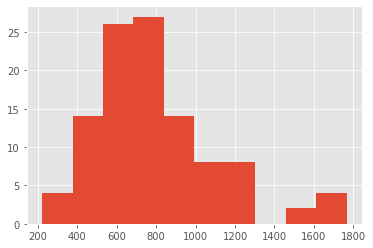

In [7]:
df["TAX"].hist()

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки. Для этого в pandas есть функция ```Series.fillna```, которая заменяет все пропущенные в колонке значения на заданное.

In [8]:
df["TAX"]

0      1639.0
1      1088.0
2      1193.0
3      1635.0
4      1732.0
        ...  
112     721.0
113     638.0
114     694.0
115     634.0
116     541.0
Name: TAX, Length: 117, dtype: float64

In [9]:
df["TAX"] = df["TAX"].fillna(df["TAX"].mean())
df["TAX"]

0      1639.0
1      1088.0
2      1193.0
3      1635.0
4      1732.0
        ...  
112     721.0
113     638.0
114     694.0
115     634.0
116     541.0
Name: TAX, Length: 117, dtype: float64

<AxesSubplot:>

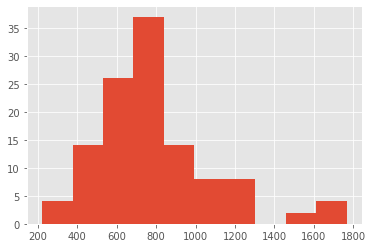

In [10]:
df["TAX"].hist()

Убедимся, что все проблемы с пропусками устранены. Длина таблицы с пропусками равна длине исходного датасета.

In [11]:
len(df.dropna())

117

#### Построение модели

Теперь можно переходить непосредственно к построению модели.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
X = df.drop(['PRICE'], axis=1)
y = df['PRICE']
X

,SQFT,FEATS,NE,CUST,COR,TAX
0,2650,7,1,1,0,1639.0
1,2600,4,1,1,0,1088.0
2,2664,5,1,1,0,1193.0
3,2921,6,1,1,0,1635.0
4,2580,4,1,1,0,1732.0
...,...,...,...,...,...,...
112,1229,3,0,0,0,721.0
113,1273,4,0,0,0,638.0
114,1165,4,0,0,0,694.0
115,1200,4,0,0,1,634.0


In [14]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Считаем качество модели (коэффициент $R^2$).

In [15]:
print(f'R^2: {model.score(X, y)}')

R^2: 0.8022436103807492


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [16]:
res = pd.DataFrame({'predictor': ['intercept'] + X.columns.tolist(),
                    'coef': [model.intercept_] + model.coef_.tolist()})
res

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, вооружившись знанием о распределении коэффициентов, либо воспользовавшись моделью из пакета ```statsmodels```.

In [17]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef
r = regression_coef(model, X, y)
r

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  


In [18]:
df.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000


Налоги сильно коррелируют с площадью. Предлагается откинуть налоги.

In [19]:
X = df[['SQFT', 'CUST']]
model.fit(X, y)
print (model.score(X, y))
regression_coef(model, X, y)

0.732096642017866


,predictor,coef,pvalue
0,intercept,114.134824,0.082734
1,SQFT,0.553635,0.000000
2,CUST,142.859931,0.005787


### Полиномиальная регрессия

In [20]:
df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])

In [21]:
df.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


Будем предсказывать цену кольца с бриллиантом от веса бриллианта. Попробуем предсказать результат не только с помощью самой переменной, но и с помощью её степеней. Первая модель будет зависеть только от самой переменной ```weight```, вторая -- от переменной ```weight^2```, а третья -- от двух этих переменных сразу.

В этих случаях, когда мы хотим попробовать в качестве фичей их степени и произведения фич, в ```sklearn.preprocessing``` есть класс ```PolynomialFeatures```. Метод ```fit_transform``` этого класса сгенерирует из данного множества фич множество одночленов заданной степени. Например, для степени 2 и фич ```a```, ```b``` будут сгенерированы фичи ```[a, b, a^2, b^2, ab]```, а при указанном параметре ```include_bias=True``` ещё и вектор-свободный член из единиц. Для данной задачи, конечно, проще было сгенерить один столбец из квадратов значений колонки ```weight```. Но нам важно ознакомиться с классом ```PolynomialFeatures``` для дальнейшего применения.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price']
X0 = poly.fit_transform(df[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2'])
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


In [23]:
X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in X0]

In [24]:
for X, model in zip(X0, models):
    model.fit(X, y)
    print (model.score(X, y))

0.978260777986033
0.970310818417109
0.9789175801893899


Получилось, что $R^2$ во всех моделях примерно одинаков. Однако не все они одинаково полезны. 

In [25]:
regression_coef(models[0], X0[0], y)

,predictor,coef,pvalue
0,intercept,-259.625907,0.0
1,weight,3721.024852,0.0


In [26]:
regression_coef(models[1], X0[1], y)

,predictor,coef,pvalue
0,intercept,141.659045,0.0
1,weight^2,7993.108083,0.0


In [27]:
regression_coef(models[2], X0[2], y)

,predictor,coef,pvalue
0,intercept,-174.130082,0.021866
1,weight,2920.130591,0.000077
2,weight^2,1739.901579,0.237265


In [28]:
import statsmodels.api as sm
X2 = sm.add_constant(X0[2])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1045.
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           1.94e-38
Time:                        14:20:14   Log-Likelihood:                -232.47
No. Observations:                  48   AIC:                             470.9
Df Residuals:                      45   BIC:                             476.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -174.1301     74.238     -2.346      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Прогнозирование временных рядов.

In [29]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [30]:
# Преобразуем строчки с датами в объект datetime
# format='%b %Y' означает, что в нашей строчке сначала идёт трёхбуквенное название месяца (%b), а затем год (%Y)
df['date'] = pd.to_datetime(df['date'], format='%b %Y')

Построим графики объёма пассажироперевозок и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. По первому графику уже прослеживается линейный тренд и мультипликативная сезонность. Но чтобы окончательно убедиться в последнем, добавим график логарифма от этой же величины. После логирафмирования циклы стали одинаковой высоты, а это и говорит о мультипликативном харакрете сезонности.

Text(0, 0.5, 'log10 от тысяч человек')

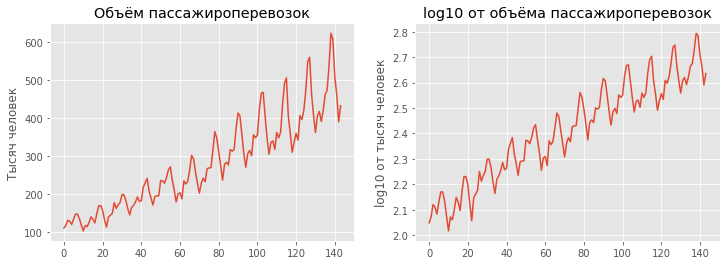

In [31]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')


Вывод: будем строить модель линейной регрессии для приближения логарифма от объёма перевозок. То есть
$$\log y_i = \beta x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайный шум.

Для удобства дальнейшего использования создадим дополнительно 12 новых месяцев для построения прогноза на них. Для этого создадим эти 12 новых дат с помощью функции ```pd.date_range```. Данный объект будет объектом класса ```DateTimeIndex``` (наследованный от класса ```Index```), и чтобы объединить их с колонкой ```df['date']```, принадлежащей классу ```datetime64```, придётся привести последнюю к классу ```Index```. Объединим два набора дат и сохраним их в объекте ```new_dates```.

Далее создадим фиктивный датафрейм ```df2```, состоящий из одной колонки с этими новыми датами, и приклеим его к исходному датафрейму ```df``` с помозью функции ```pd.merge```. Эта функция склеивает два датасета по указанному набору колонок (параметр ```on```) и по указанному правилу склейки (параметр ```how```). В ```on``` указываем одну общую колонку ```date```, по которой нужно произвести склейку. В ```how``` указываем ```right```, что означает следующее: 
возьми весь правый датасет и приклей к нему левый датасет по условию совпадения значений колонки ```on```, а в случае если для значений из правой колонки ```on``` не найдётся соотвествующих значений в левой колонке ```on```, то тогда приклей ```NaN``` значения. Вообще говоря, опция ```how``` соответствует опциям ```JOIN``` в языке SQL (```LEFT JOIN```, ```RIGHT_JOIN```, ```INNER JOIN```, ```OUTER_JOIN```).

In [32]:
# Создаём последовательность месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')
# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right')

<ipython-input-32-d2579f806d3b>:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  new_dates = pd.Index(df['date']) | new_dates


Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). И прологарифмируем таргет.

In [33]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

Создадим 12 колонок ```season_1```, ```season_2```, ..., ```season_12```, в которые поместим индикаторы соответствующего месяца. Чтобы достать порядковый номер месяца в каждой строчке, применим последовательно пару методов ```dt``` и ```month``` к колонке ```df['date']```. Внутри цикла будем проверять, равен ли очередной месяц текущему значению из цикла.

In [34]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x

In [64]:
df.tail(24)

,date,series_g,month_num,log_y,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
132,1960-01-01,417.0,133,2.620136,True,False,False,False,False,False,False,False,False,False,False,False
133,1960-02-01,391.0,134,2.592177,False,True,False,False,False,False,False,False,False,False,False,False
134,1960-03-01,419.0,135,2.622214,False,False,True,False,False,False,False,False,False,False,False,False
135,1960-04-01,461.0,136,2.663701,False,False,False,True,False,False,False,False,False,False,False,False
136,1960-05-01,472.0,137,2.673942,False,False,False,False,True,False,False,False,False,False,False,False
137,1960-06-01,535.0,138,2.728354,False,False,False,False,False,True,False,False,False,False,False,False
138,1960-07-01,622.0,139,2.793790,False,False,False,False,False,False,True,False,False,False,False,False
139,1960-08-01,606.0,140,2.782473,False,False,False,False,False,False,False,True,False,False,False,False
140,1960-09-01,508.0,141,2.705864,False,False,False,False,False,False,False,False,True,False,False,False
141,1960-10-01,461.0,142,2.663701,False,False,False,False,False,False,False,False,False,True,False,False


Правда, для устранения линейной зависимости между колонками, один из сезонных индикаторов придётся исключить. Пусть базовым месяцем будет январь.

In [51]:
# xrange(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(1, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]

In [52]:
X

,month_num,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
0,1,True,False,False,False,False,False,False,False,False,False,False,False
1,2,False,True,False,False,False,False,False,False,False,False,False,False
2,3,False,False,True,False,False,False,False,False,False,False,False,False
3,4,False,False,False,True,False,False,False,False,False,False,False,False
4,5,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,False,False,False,False,False,False,False,True,False,False,False,False
152,153,False,False,False,False,False,False,False,False,True,False,False,False
153,154,False,False,False,False,False,False,False,False,False,True,False,False
154,155,False,False,False,False,False,False,False,False,False,False,True,False


Настраиваем линейную регрессионную модель.

In [53]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression()

<AxesSubplot:>

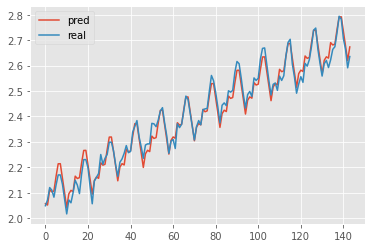

In [54]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

Теперь построим предсказание для всей матрицы ```X```, включая неизвестные 12 месяцев.

<AxesSubplot:>

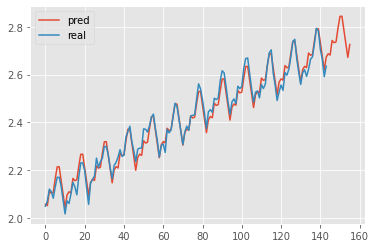

In [55]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

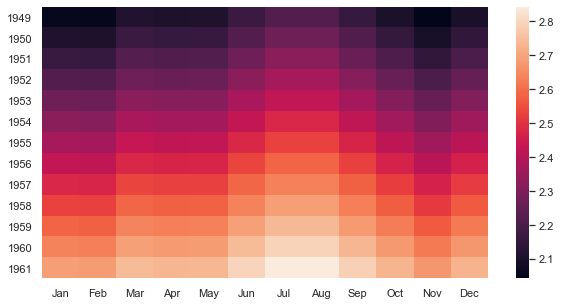

In [68]:
import seaborn as sns
sns.set_theme()

pred_df = pd.DataFrame(pred['pred'].to_numpy().reshape((13, 12)),
                      columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                      index=range(1949, 1962))

plt.figure(1, (10, 5))
ax = sns.heatmap(pred_df)


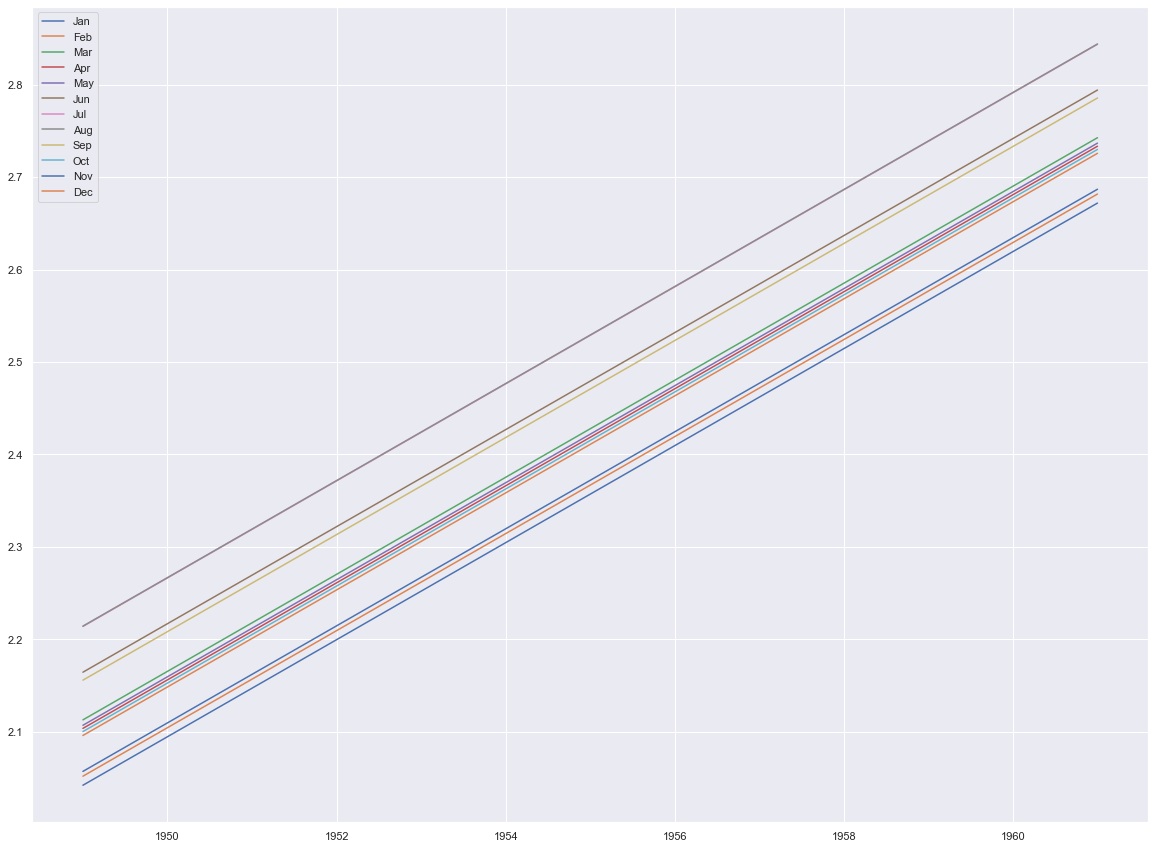

In [80]:
plt.figure(1, (20, 15))
plt.plot(pred_df, label=pred_df.columns)
plt.legend()
plt.show()

<p> График имеет очевидный тренд на возрастание (все значения на 1961 год выше любого значения за 1949)
<p> Так же наблюдается сезонность - если смотреть на значения по годам, то каждый год имеет минимальные значения в ноябре и феврале и максимальные значение в июле и августе